# Quantitative analysis

In [28]:
import csv
import itertools 
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import pickle
import seaborn as sb
from scipy.cluster.hierarchy import linkage, to_tree, fcluster

user = 'xxxx' # fill in MySQL user
password = 'xxxx' # fill in MySQL pw
db = 'xxxx' # fill in MySQL database name
socket = '/x/x/x/x.sock' # fill in MySQL unix socket

## Data

### Wrangle accessions

In [29]:
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
cursor = cnx.cursor()
cursor.execute("SELECT DISTINCT(UniProt_ID), type, type_evidence, type_probability FROM UniProt;")

up_acc = []
types = []
type_evidence = []
type_probability = []
for i in cursor:
    up_acc.append(i[0])
    types.append(i[1])
    type_evidence.append(i[2])
    type_probability.append(i[3])
tmp = {'type' : types, 'type_evidence' : type_evidence, 'type_probability' : type_probability}
main_table = pd.DataFrame(tmp, index=up_acc)
#main_table

PhaLP includes 7067 endolysins, 2763 VALs and 2008 uncertainly classified phage lytic proteins.


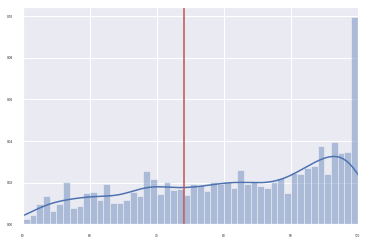

In [30]:
### check and set confidence level threshold for protein typing
sb.distplot(list(main_table.drop([i for i in main_table.index if main_table.loc[i, 'type_evidence'] != 'ML prediction']).type_probability), 
            bins=50)
plt.xlim([50, 100])
plt.axvline(74, c='r')

endolysins = [i for i in main_table.index if main_table.loc[i, 'type'] == 'endolysin' and main_table.loc[i, 'type_probability'] >= 75]
vals = [i for i in main_table.index if main_table.loc[i, 'type'] == 'VAL' and main_table.loc[i, 'type_probability'] >= 75]
unclass = [i for i in main_table.index if i not in endolysins and i not in vals]
print('PhaLP includes', len(endolysins), 'endolysins,', len(vals), 'VALs and', len(unclass), 
      'uncertainly classified phage lytic proteins.')

Endolysins and VALs used for analyses will consist of the proteins that have been called as such with a certainty of at least 75%.

In [31]:
### VALs vs endolysins
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)

cursor = cnx.cursor()
cursor.execute("SELECT ur.protein_sequence, up.UniProt_ID FROM UniProt as up JOIN UniRef as ur WHERE up.UniRef_ID = ur.UniRef_ID;")

endolysin_seqs = []
val_seqs = []
acc2seq = {}
for i in cursor:
    if i[1] in endolysins:
        endolysin_seqs.append(i[0])
    elif i[1] in vals:
        val_seqs.append(i[0])
    acc2seq[i[1]] = i[0]

print("There are", len(set(acc2seq.values())), "unique AA sequences in total.")
print("There are", len(set(val_seqs)), "unique VAL sequences. These are on average", 
      int(np.median([len(i) for i in val_seqs])), "AAs long.")
print("There are", len(set(endolysin_seqs)), "unique endolysin sequences. These are on average", 
      int(np.median([len(i) for i in endolysin_seqs])), "AAs long.")

There are 7957 unique AA sequences in total.
There are 2084 unique VAL sequences. These are on average 954 AAs long.
There are 4515 unique endolysin sequences. These are on average 250 AAs long.


### Wrangle domains

In [5]:
domains = pd.read_csv("domains/custom_domain_clusters.csv", sep=',', index_col="accession", 
                      usecols=['accession', 'abbreviation', 'class', 'sub'])

In [6]:
cbds = []
pgas = []
pgaps = []
pgps = []
pggs = []
pgms = []
pgmts = []
pglts = []
misc = []
sorted_doms = []
for i in domains.index:
    if domains.loc[i]['class'] == 'CBD' and domains.loc[i]['abbreviation'] not in sorted_doms:
        cbds.append(domains.loc[i]['abbreviation'])
        sorted_doms.append(domains.loc[i]['abbreviation'])
    elif domains.loc[i]['class'] == 'EAD' and domains.loc[i]['abbreviation'] not in sorted_doms:
        if domains.loc[i]['sub'] == 'A':
            pgas.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'A+P':
            pgaps.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'P':
            pgps.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'G':
            pggs.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'M':
            pgms.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'M+T':
            pgmts.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'T':
            pglts.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
    elif domains.loc[i]['class'] == 'MISC' and domains.loc[i]['abbreviation'] not in sorted_doms:
        misc.append(domains.loc[i]['abbreviation'])
        sorted_doms.append(domains.loc[i]['abbreviation'])

amidases = pgas + pgaps
peptidases = pgaps + pgps 
muramidases = pgms + pgmts
lts = pgmts + pglts 
eads = pgas + pgaps + pgps + pggs + pgms + pgmts + pglts

In [7]:
### Load in architectures
domains_per_entry = {}
with open('simplified_architectures.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        domains_per_entry[row[0]] = [i for idx, i in enumerate(row) if idx != 0 and i != '']
print(len(set(itertools.chain.from_iterable(domains_per_entry.values()))), 'distinct domains across', len(list(domains_per_entry.keys())), 'entries.')
lens = [len(v) for v in domains_per_entry.values()]
print('On average', round(np.mean(lens), 2), 'domains found per entry, with a max of', max(lens))
print('{} entries do not have any domains linked to them.'.format(len([i for i in up_acc if i not in list(domains_per_entry.keys())])))

105 distinct domains across 11584 entries.
On average 1.58 domains found per entry, with a max of 8
254 entries do not have any domains linked to them.


In [8]:
endo_archs = {k:v for k, v in domains_per_entry.items() if k in endolysins}
endo_doms = set(itertools.chain.from_iterable(endo_archs.values()))
val_archs = {k:v for k, v in domains_per_entry.items() if k in vals}
val_doms = set(itertools.chain.from_iterable(val_archs.values()))
uncl_archs = {k:v for k, v in domains_per_entry.items() if k in unclass}
uncl_doms = set(itertools.chain.from_iterable(uncl_archs.values()))

print('ALL:', len(cbds), "unique CBDs,", len(eads), "unique EADs and", len(misc), "unique miscs.")
print('Endolysins:', len([i for i in endo_doms if i in cbds]), "unique CBDs,", 
      len([i for i in endo_doms if i in eads]), "unique EADs and", 
      len([i for i in endo_doms if i in misc]), "unique miscs.")
print('VALs:', len([i for i in val_doms if i in cbds]), "unique CBDs,", 
      len([i for i in val_doms if i in eads]), "unique EADs and", 
      len([i for i in val_doms if i in misc]), "unique miscs.")
print('Unclassifieds:', len([i for i in uncl_doms if i in cbds]), "unique CBDs,", 
      len([i for i in uncl_doms if i in eads]), "unique EADs and", 
      len([i for i in uncl_doms if i in misc]), "unique miscs.")

ALL: 12 unique CBDs, 27 unique EADs and 66 unique miscs.
Endolysins: 12 unique CBDs, 23 unique EADs and 10 unique miscs.
VALs: 1 unique CBDs, 14 unique EADs and 49 unique miscs.
Unclassifieds: 10 unique CBDs, 24 unique EADs and 23 unique miscs.


### Wrangle hosts

In [9]:
### get annotation
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
cursor.execute("SELECT DISTINCT lineage_phylum, lineage_class, lineage_order, lineage_family, lineage_genus FROM hosts;")

host = pd.DataFrame(index=np.arange(0, 1000), columns=["Phylum", "Class", "Order", "Family", "Genus"])
for idx, i in enumerate(cursor):
    host.iloc[idx]["Phylum"] = i[0]
    host.iloc[idx]["Class"] = i[1]
    host.iloc[idx]["Order"] = i[2]
    host.iloc[idx]["Family"] = i[3]
    host.iloc[idx]["Genus"] = i[4]
    
host["Gramtype"] = '~'
to_remove = []
for i in host.index:
    if host.loc[i]['Order'] in ['Synechococcales', 'Nostocales', 'Oscillatoriales', 'Chroococcales']:
        host.loc[i]['Class'] = 'Cyanophyceae' 
    elif host.loc[i]['Genus'] == 'Plesiomonas':
        host.loc[i]['Family'] = 'Enterobacteriaceae'
    elif host.loc[i]['Genus'] == 'Exiguobacterium':
        host.loc[i]['Family'] = 'Bacillaceae'
    elif host.iloc[i]["Family"] == 'Thermoanaerobacterales Family III. Incertae Sedis':
        host.iloc[i]["Family"] = 'Thermoanaerobacterales 3'
    ### remove unknowns
    if all(host.iloc[i].isna()):
        to_remove.append(i)
    elif pd.isna(host.iloc[i]["Genus"]):
        to_remove.append(i)
    ### gram annotation
    if host.loc[i]["Phylum"] in ['Actinobacteria', 'Firmicutes']:
        if host.loc[i]["Family"] != 'Mycobacteriaceae':
            host.loc[i]["Gramtype"] = '+'
    elif host.loc[i]["Phylum"] in ['Proteobacteria', 'Bacteroidetes', 'Cyanobacteria', 
                                   'Spirochaetes', 'Fusobacteria', 'Deinococcus-Thermus']:
        host.loc[i]["Gramtype"] = '-'

host = host.fillna('Unknown')
host = host.drop(to_remove, axis=0)

### sort genera
gpos = host[host.Gramtype == '+'].sort_values(by=['Phylum', 'Class', 'Order', 'Family'])
gneg = host[host.Gramtype == '-'].sort_values(by=['Phylum', 'Class', 'Order', 'Family'])
gamb = host[host.Gramtype == '~'].sort_values(by=['Phylum', 'Class', 'Order', 'Family'])

sorted_genera = list(pd.concat([gpos, gamb, gneg]).Genus)

In [10]:
### Get hosts for each entry
host_per_entry = {}
for i in list(domains_per_entry.keys()):
    host_per_entry[i] = []
    cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
    cursor = cnx.cursor()
    query = "SELECT h.lineage_genus FROM UniProt as up JOIN link_phage_host as l JOIN hosts as h WHERE up.UniProt_ID = '" + i + "' AND up.phages_ID = l.phages_ID AND l.hosts_ID = h.hosts_ID;"
    cursor.execute(query)
    
    tmp = []
    for j in cursor:
        tmp.append(j[0])
    
    host_per_entry[i] = [k for k in set(tmp) if k != None]

#remove none values
filtered = {k: v for k, v in host_per_entry.items() if None not in v and len(v) != 0}
host_per_entry.clear()
host_per_entry.update(filtered)
print("Amount of accessions with (at least one) host genus linked: ")
print(len(host_per_entry))
lens = [len(v) for v in host_per_entry.values()]
print('On average', round(np.mean(lens), 1), 'host found per entry, with a max of', max(lens))
print('Total of', len(list(set(itertools.chain.from_iterable(host_per_entry.values())))), 'distinct host genera.')

Amount of accessions with (at least one) host genus linked: 
10960
On average 1.0 host found per entry, with a max of 6
Total of 172 distinct host genera.


### Wrangle phages

In [11]:
### Get annotation
phage_per_entry = {}
for i in list(domains_per_entry.keys()):
    phage_per_entry[i] = []
    cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
    cursor = cnx.cursor()
    query = "SELECT p.lineage_family FROM UniProt as up JOIN phages as p WHERE up.UniProt_ID = '" + i + "' AND up.phages_ID = p.phages_ID;"
    cursor.execute(query)
    
    tmp = []
    for j in cursor:
        tmp.append(j[0])
    
    phage_per_entry[i] = [k for k in set(tmp) if k != None]
    if len(phage_per_entry[i]) == 0:
        phage_per_entry[i] = 'Unknown'
    else:
        phage_per_entry[i] = phage_per_entry[i][0]
        
### sort
sorted_phage_fams = ['Ackermannviridae', 'Herelleviridae', 'Myoviridae', 'Podoviridae', 'Siphoviridae', 'Microviridae', 'Tectiviridae']

## General figures

In [12]:
### globular proteins
print(round(len([i for i in lens if i == 1])/len(up_acc)*100, 2), "% of entries only contain a single domain (n = {})".format(len([i for i in lens if i == 1])))
print(len([list(domains_per_entry.values())[idx] for idx,i in enumerate(lens) if i == 1 and list(domains_per_entry.values())[idx][0] in cbds])/len(up_acc)*100, "% of entries only contain a CBD (n = {})".format(len([list(domains_per_entry.values())[idx] for idx,i in enumerate(lens) if i == 1 and list(domains_per_entry.values())[idx][0] in cbds])))

print(len([list(domains_per_entry.values())[idx] for idx,i in enumerate(lens) if i == 1 and list(domains_per_entry.values())[idx][0] in eads])/len(up_acc)*100, "% of entries only contain an EAD (n = {}).".format(len([list(domains_per_entry.values())[idx] for idx,i in enumerate(lens) if i == 1 and list(domains_per_entry.values())[idx][0] in eads])))
print(len([list(domains_per_entry.values())[idx] for idx,i in enumerate(lens) if i == 1 and list(domains_per_entry.values())[idx][0] in cbds])/len([i for i in lens if i == 1])*100, "% of globular proteins only contain a CBD.")
print(len([list(domains_per_entry.values())[idx] for idx,i in enumerate(lens) if i == 1 and list(domains_per_entry.values())[idx][0] in misc])/len([i for i in lens if i == 1])*100, "% of globular proteins contain an misc.")

print('For endolysins specifically, these figures are:')
print('- globular:', round(len([1 for v in endo_archs.values() if len(v) == 1])/len(endolysins)*100, 2), "% (n = {})".format(len([1 for v in endo_archs.values() if len(v) == 1])))
print('- EAD-only:', round(len([1 for v in endo_archs.values() if len(v) == 1 and v[0] in eads])/len(endolysins)*100, 2), "% (n = {})".format(len([1 for v in endo_archs.values() if len(v) == 1 and v[0] in eads])))
print('- CBD-only:', round(len([1 for v in endo_archs.values() if len(v) == 1 and v[0] in cbds])/len(endolysins)*100, 2), "% (n = {})".format(len([1 for v in endo_archs.values() if len(v) == 1 and v[0] in cbds])))

print('For VALs specifically, these figures are:')
print('- globular:', round(len([1 for v in val_archs.values() if len(v) == 1])/len(vals)*100, 2), "% (n = {})".format(len([1 for v in val_archs.values() if len(v) == 1])))
print('- EAD-only:', round(len([1 for v in val_archs.values() if len(v) == 1 and v[0] in eads])/len(vals)*100, 2), "% (n = {})".format(len([1 for v in val_archs.values() if len(v) == 1 and v[0] in eads])))
print('- CBD-only:', round(len([1 for v in val_archs.values() if len(v) == 1 and v[0] in cbds])/len(vals)*100, 2), "% (n = {})".format(len([1 for v in val_archs.values() if len(v) == 1 and v[0] in cbds])))

91.56 % of entries only contain a single domain (n = 10839)
2.2047643182970096 % of entries only contain a CBD (n = 261)
80.99341104916371 % of entries only contain an EAD (n = 9588).
2.4079712150567394 % of globular proteins only contain a CBD.
9.133683919180736 % of globular proteins contain an misc.
For endolysins specifically, these figures are:
- globular: 63.39 % (n = 4480)
- EAD-only: 62.73 % (n = 4433)
- CBD-only: 0.59 % (n = 42)
For VALs specifically, these figures are:
- globular: 52.08 % (n = 1439)
- EAD-only: 51.94 % (n = 1435)
- CBD-only: 0.0 % (n = 0)


In [14]:
### modular proteins
print(round(len([i for i in lens if i > 1])/len(up_acc)*100, 2), "% of entries contain more than one domain (n = {})".format(len([i for i in lens if i > 1])))

print(len([idx for idx,i in enumerate(lens) if i > 1 and set(list(domains_per_entry.values())[idx]).issubset(set(eads))])/len(up_acc)*100, "% of entries are eads-only, modular proteins (n = {}).".format(len([idx for idx,i in enumerate(lens) if i > 1 and set(list(domains_per_entry.values())[idx]).issubset(set(eads))])))
print(len([idx for idx,i in enumerate(lens) if i > 1 and set(list(domains_per_entry.values())[idx]).issubset(set(cbds))])/len(up_acc)*100, "% of modular are cbds-only, modular proteins (n = {}).".format(len([idx for idx,i in enumerate(lens) if i > 1 and set(list(domains_per_entry.values())[idx]).issubset(set(cbds))])))

1.02 % of entries contain more than one domain (n = 121)
0.768775872264932 % of entries are eads-only, modular proteins (n = 91).
0.01689617301681169 % of modular are cbds-only, modular proteins (n = 2).


In [15]:
### proteins without CBDs
c = 0
for i in domains_per_entry:
    if len([j for j in domains_per_entry[i] if j in cbds]) == 0:
        c += 1
    
print(c/len(up_acc)*100, "% of entries don't have CBDs (n = {}).".format(c))

78.56720452817437 % of entries don't have CBDs (n = 9300).


In [16]:
### multiple CBDs
c = 0
n_repeats = []
for i in domains_per_entry:
    if len([j for j in domains_per_entry[i] if j in cbds]) > 1:
        c += 1
        if len(set([j for j in domains_per_entry[i] if j in cbds])) == 1:
            n_repeats.append(len([j for j in domains_per_entry[i] if j in cbds]))
    
print(c/len(up_acc)*100, "% of entries have multiple CBDs (n = {}).".format(c))
print(len(n_repeats)/len(up_acc)*100, "% of entries have repeated CBDs (n = {}).".format(len(n_repeats)))
print("CBD-repeats occur in lengths of", min(n_repeats), "to", max(n_repeats),"times.")

4.139562389118864 % of entries have multiple CBDs (n = 490).
3.624229112106108 % of entries have repeated CBDs (n = 429).
CBD-repeats occur in lengths of 2 to 7 times.


In [17]:
### multiple EADs
c = 0
n_repeats = []
for i in domains_per_entry:
    if len([j for j in domains_per_entry[i] if j in eads]) > 1:
        c += 1
        if len(set([j for j in domains_per_entry[i] if j in eads])) == 1:
            n_repeats.append(len([j for j in domains_per_entry[i] if j in eads]))
    
print(c/len(up_acc)*100, "% of entries have multiple EADs (n = {}).".format(c))
print(len(n_repeats)/len(up_acc)*100, "% of entries have repeated EADs (n = {}).".format(len(n_repeats)))
#print("EAD-repeats occur in lengths of", min(n_repeats), "to", max(n_repeats),"times.")

15.181211455605306 % of entries have multiple EADs (n = 1797).
0.0 % of entries have repeated EADs (n = 0).


In [19]:
### CBDs in VALs
val_cbds = []
val_with_cbds = []
for i in val_archs:
    if len([j for j in val_archs[i] if j in cbds]) > 0:
        val_with_cbds.append(i)
        val_cbds.append([j for j in val_archs[i] if j in cbds])
print((len(val_cbds)/len(val_archs))*100, "% percent of VALs contain CBDs.")
print(set(itertools.chain.from_iterable(val_cbds)))
print(len(val_with_cbds))

0.6954612005856515 % percent of VALs contain CBDs.
{'LysM'}
19


In [19]:
### VAL composition vs endolysin composition
endolysin_arch = {i:domains_per_entry[i] for i in endolysins if i in domains_per_entry}
val_arch = {i:domains_per_entry[i] for i in vals if i in domains_per_entry}
doms_endo = set(itertools.chain.from_iterable(endolysin_arch.values()))
doms_val = set(itertools.chain.from_iterable(val_arch.values()))
doms_unann = set(itertools.chain.from_iterable(domains_per_entry.values())) - doms_endo - doms_val
doms_both = set(itertools.chain.from_iterable(endolysin_arch.values())).intersection(set(itertools.chain.from_iterable(val_arch.values())))

print("There are", len(doms_endo), "different domains in endolysins.")
print("There are", len(doms_val), "different domains in VALs.")
print(len(doms_both), "domains occur in both endolysins and VALs. Hence", len(doms_endo) - len(doms_both), "and",
      len(doms_val) - len(doms_both), "are unique to endolysins and VALs, respectively, with", 
      len(doms_unann), "occurring only in unannotated proteins.")

There are 45 different domains in endolysins.
There are 64 different domains in VALs.
16 domains occur in both endolysins and VALs. Hence 29 and 48 are unique to endolysins and VALs, respectively, with 12 occurring only in unannotated proteins.


In [20]:
### Occurrence of each domain cluster
dom_occ = np.zeros((len(sorted_doms)))
for i in domains_per_entry:
    for j in domains_per_entry[i]:
        dom_occ[sorted_doms.index(j)] += 1
#list(dom_occ)

In [21]:
### Occurrence of each domain cluster in endolysins
dom_end_occ = np.zeros((len(sorted_doms)))
for i in domains_per_entry:
    if i in endolysins:
        for j in domains_per_entry[i]:
            dom_end_occ[sorted_doms.index(j)] += 1
#list(dom_end_occ)

In [22]:
### C-terminal CBDs
cc = 0
cct = 0
for i in domains_per_entry:
    if len([j for j in domains_per_entry[i] if j in cbds]) != 0:
        cc += 1
        if domains_per_entry[i][-1] in cbds:
            cct += 1
print("When CBDs are present, they are C-terminal in", cct/cc * 100, "% of instances.")

When CBDs are present, they are C-terminal in 87.95971978984238 % of instances.


In [23]:
### N-terminals
mnt = 0
ennt = 0
ent = 0
cv = 0
for i in vals:
    cv += 1
    if i in domains_per_entry:
        if domains_per_entry[i][0] in misc:
            mnt += 1
            if len(domains_per_entry[i]) > 1:
                if domains_per_entry[i][1] in eads:
                    ennt += 1
        elif domains_per_entry[i][0] in eads:
            ent += 1
print("In VALs, miscs are are N-terminal in", mnt/cv * 100, "%(n =", mnt, ") of instances,")
print("followed by an EAD in", ennt/mnt * 100, "% (n =", ennt, ")of instances.")
print("EADs are N-terminal in VALs in", ent/cv * 100, "% (n =", ent,").")

ent = 0
ce = 0
for i in endolysins:
    if i in domains_per_entry:
        ce += 1
        if domains_per_entry[i][0] in eads:
                ent += 1
print("In endolysins, EADs are are N-terminal in", ent/ce * 100, "% (n =", ent,") of instances.")

In VALs, miscs are are N-terminal in 32.464712269272525 %(n = 897 ) of instances,
followed by an EAD in 93.9799331103679 % (n = 843 )of instances.
EADs are N-terminal in VALs in 66.304741223308 % (n = 1832 ).
In endolysins, EADs are are N-terminal in 96.91617199942087 % (n = 6694 ) of instances.


In [24]:
c = 0
cc = 0
ec = 0
nc = 0
for i in domains_per_entry:
    rep = False
    cbd_rep = False
    ead_rep = False
    misc_rep = False
    for jdx in range(len(domains_per_entry[i])-1):
        if domains_per_entry[i][jdx] == domains_per_entry[i][jdx+1]:
            rep = True
            if domains_per_entry[i][jdx] in cbds:
                cbd_rep = True
            elif domains_per_entry[i][jdx] in eads:
                ead_rep = True
                #print(domains_per_entry[i][jdx])
            elif domains_per_entry[i][jdx] in misc:
                misc_rep = True
    if rep == True:
        c += 1
    if cbd_rep == True:
        cc += 1
    if ead_rep == True:
        ec += 1
    if misc_rep == True:
        nc += 1
        
print(c/len(domains_per_entry)*100, "% (n =", c, ") of architectures have repeats.")
print(cc/len(domains_per_entry)*100, "% (n =", cc, ") of architectures have CBD repeats.")
print(ec/len(domains_per_entry)*100, "% (n =", ec, ") of architectures have EAD repeats.")
print(nc/len(domains_per_entry)*100, "% (n =", nc, ") of architectures have misc repeats.")

4.6875 % (n = 543 ) of architectures have repeats.
3.798342541436464 % (n = 440 ) of architectures have CBD repeats.
0.008632596685082872 % (n = 1 ) of architectures have EAD repeats.
0.880524861878453 % (n = 102 ) of architectures have misc repeats.


### Host-related figures 

In [13]:
### likelihood of CBDs
cbd_containing_gpos = 0
cbd_containing_gneg = 0
gpos_known = len([k for k in host_per_entry if set(host_per_entry[k]).intersection(set(gpos.Genus))])
gneg_known = len([k for k in host_per_entry if set(host_per_entry[k]).intersection(set(gneg.Genus))])

for k in host_per_entry:
    if set(host_per_entry[k]).intersection(set(gpos.Genus)):
        if len(set(domains_per_entry[k]).intersection(set(cbds))) > 0:
            cbd_containing_gpos += 1
    elif set(host_per_entry[k]).intersection(set(gneg.Genus)):
        if len(set(domains_per_entry[k]).intersection(set(cbds))) > 0:
            cbd_containing_gneg += 1
print('The likelihood of a G+ targeting protein containing a CBD is {}%'.format(round(cbd_containing_gpos/gpos_known * 100, 2)))
print('The likelihood of a G- targeting protein containing a CBD is {}%'.format(round(cbd_containing_gneg/gneg_known * 100, 2)))

The likelihood of a G+ targeting protein containing a CBD is 30.95%
The likelihood of a G- targeting protein containing a CBD is 7.48%


In [14]:
### highest diversity of CBDs
all_hosts = list(set(itertools.chain.from_iterable(host_per_entry.values())))
highest_c = 0 
highest_g = False
for i in all_hosts:
    linked_cbds = []
    for j in domains_per_entry:
        if j in host_per_entry:
            if i in host_per_entry[j]:
                linked_cbds.extend(list(set(domains_per_entry[j]).intersection(cbds)))
    if len(set(linked_cbds)) > highest_c:
        highest_c = len(set(linked_cbds))
        highest_g = [i]
    elif len(set(linked_cbds)) == highest_c:
        if not highest_g:
            highest_g = [i]
        else:
            highest_g.append(i)
print(highest_g, 'have the highest number of linked CBDs:', highest_c)

['Bacillus', 'Streptococcus'] have the highest number of linked CBDs: 5


In [15]:
### unique CBDs
unique_cbd_accs = [i for i in domains_per_entry if 'LysM' in domains_per_entry[i]]
unique_cbd_hosts = []
for i in unique_cbd_accs:
    if i in host_per_entry:
        unique_cbd_hosts.extend(host_per_entry[i])
print(set(unique_cbd_hosts))

{'Streptococcus', 'Enterococcus', 'Lactobacillus', 'Cronobacter', 'Arthrobacter', 'Microbacterium', 'Streptomyces', 'Geobacillus', 'Klebsiella', 'Thermus', 'Weissella', 'Escherichia', 'Vibrio', 'Aerococcus', 'Rhizobium', 'Virgibacillus', 'Salmonella', 'Oenococcus', 'Lactococcus', 'Exiguobacterium', 'Rhodococcus', 'Bacillus', 'Paeniglutamicibacter', 'Listeria', 'Pectobacterium'}


In [16]:
### modular G- lysins
gramneg_accs = [i for i in host_per_entry if len(set(host_per_entry[i]).intersection(set(gneg.Genus))) != 0]
gramnneg_cbds = []
for i in gramneg_accs:
    if i in domains_per_entry:
        if len(set(domains_per_entry[i]).intersection(set(cbds))) != 0:
            gramnneg_cbds.extend(list(set(domains_per_entry[i]).intersection(set(cbds))))
print(np.unique(gramnneg_cbds, return_counts=True))

(array(['LysM', 'PG_1', 'PG_3', 'SH3'], dtype='<U4'), array([ 14, 130, 213,   5]))


## Host-specific evolution of phage lytic proteins by recombination

### With various

In [17]:
### Set properties
heatmap_rows = sorted_genera + ['All G+', 'All G-'] + sorted_phage_fams
sorted_doms = cbds + eads + misc
heatmap_cols = sorted_doms + ['All CBDs', 'All N-acetylmuramoyl-L-alanine amidases', 
                              'All peptidases', 'All N-acetyl-β-D-muramidases', 'All lytic transglycosylases']

In [18]:
### Calculate fraction of accessions for a certain host that has a specific domain
genus_specific_entries = []
domain_genus_quant = np.zeros((len(heatmap_rows), len(heatmap_cols)))
for idx, i in enumerate(heatmap_rows):
    if i == 'All G+':
        G_pos = set(gpos.Genus)
        entries_host = [k for k in host_per_entry if set(host_per_entry[k]).intersection(G_pos)]
        genus_specific_entries.append(len(entries_host))
        print("amount of positive entries: ")
        print(len(entries_host))
    elif i == 'All G-':
        G_neg = set(gneg.Genus)
        entries_host = [k for k in host_per_entry if set(host_per_entry[k]).intersection(G_neg)]
        genus_specific_entries.append(len(entries_host))
        print("amount of negative entries: ")
        print(len(entries_host))
    elif i in sorted_phage_fams:
        entries_host = [k for k in phage_per_entry if phage_per_entry[k] == i]
        genus_specific_entries.append(len(entries_host))
    else: 
        entries_host = [k for k in host_per_entry if i in host_per_entry[k]] #entries that have this host
        genus_specific_entries.append(len(entries_host))
    for jdx, j in enumerate(heatmap_cols):
        if j == 'All CBDs': #entries that have this host & a binding domain
            CBDs = set(cbds)
            entries_host_dom = [l for l in entries_host if CBDs.intersection(set(domains_per_entry[l]))] 
        elif j == 'All N-acetylmuramoyl-L-alanine amidases': #entries that have this host & an amidase
            entries_host_dom = [l for l in entries_host if set(amidases).intersection(set(domains_per_entry[l]))]
        elif j == 'All peptidases': #entries that have this host & a peptidase
            entries_host_dom = [l for l in entries_host if set(peptidases).intersection(set(domains_per_entry[l]))]
        elif j == 'All N-acetyl-β-D-muramidases': #entries that have this host & a muramidase/lysozyme
            entries_host_dom = [l for l in entries_host if set(muramidases).intersection(set(domains_per_entry[l]))]
        elif j == 'All lytic transglycosylases': #entries that have this host & a lytic transglycosylase
            entries_host_dom = [l for l in entries_host if set(lts).intersection(set(domains_per_entry[l]))]
        else:
            entries_host_dom = [l for l in entries_host if j in domains_per_entry[l]] #entries that have this host & domain
        domain_genus_quant[idx, jdx] = len(entries_host_dom)/len(entries_host) #calculate fraction

amount of positive entries: 
4624
amount of negative entries: 
4826


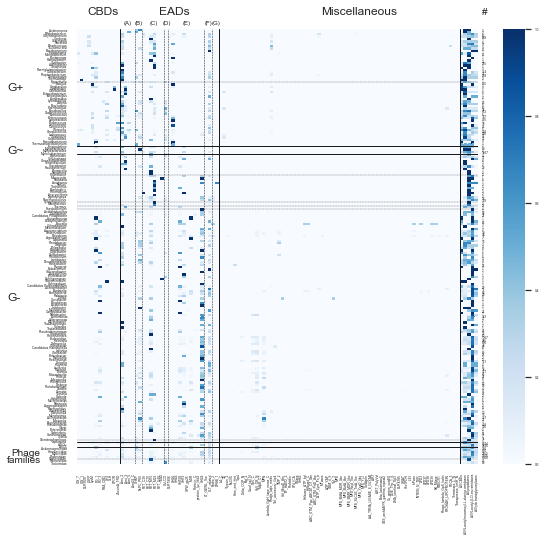

In [19]:
### Create heatmap
plt.figure(figsize=(9, 8))
sb.set(font_scale = 0.3)
plt.tight_layout()
sb.heatmap(pd.DataFrame(domain_genus_quant, index=heatmap_rows, columns=heatmap_cols), cmap='Blues',
                xticklabels=True, yticklabels=True)
plt.axhline(len(gpos), xmin = -0.1, ls='-', lw=1, c='k') #G+ vs G~
plt.text(-19, len(gpos)/2 + 1, "G+", fontsize=12)
plt.axhline(len(gpos)+len(gamb), ls='-', lw=1, c='k') #G~ vs G-
plt.text(-19, len(gpos)+(len(gamb)/2) + 1.3, "G~", fontsize=12)
plt.text(-19, len(gpos)+len(gamb)+(len(gneg)/2) + 1, "G-", fontsize=12)
plt.axhline(len(gpos)+len(gamb)+len(gneg), ls='-', lw=1, c='k') #G- vs summary
plt.axhline(len(gpos)+len(gamb)+len(gneg)+2, ls='-', lw=1, c='k') #summary vs phage fams
plt.text(-18, len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2) + 2, "Phage", fontsize=10)
plt.text(-19, len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2) + 5, "families", fontsize=10)

plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Firmicutes'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Cyanobacteria'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Deinococcus-Thermus'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Fusobacteria'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Proteobacteria'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Spirochaetes'), ls='--', lw=0.3, c='k')
plt.axhline(heatmap_rows.index('Microviridae'), ls='--', lw=0.3, c='k')

plt.text((len(cbds)/2)-3, -6, "CBDs", fontsize=12)
plt.axvline(len(cbds), ls='-', lw=1, c='k') #CBDs vs EADs
plt.text(len(cbds) + (len(eads)/2)-3, -6, "EADs", fontsize=12)
plt.axvline(len(cbds)+len(eads), ls='-', lw=1, c='k') #EADs vs misc
plt.text(len(cbds)+len(eads) + (len(misc)/2)-5, -6, "Miscellaneous", fontsize=12)
plt.axvline(len(cbds)+len(eads)+len(misc), ls='-', lw=1, c='k') #EADs vs misc

plt.text(len(cbds)+(len(pgas)/2)-1, -2, "(A)", fontsize=6)
plt.axvline(len(cbds)+len(pgas), ls='--', lw=0.5, c='k') #PGAs vs PGAPs
plt.text(len(cbds)+len(pgas)+(len(pgaps)/2)-1, -2, "(B)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps), ls='--', lw=0.5, c='k') #PGAPs vs PGPs
plt.text(len(cbds)+len(pgas)+len(pgaps)+(len(pgps)/2)-1, -2, "(C)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps), ls='--', lw=0.5, c='k') #PGPs vs PGGs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+(len(pggs)/2)-1, -2, "(D)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs), ls='--', lw=0.5, c='k') #PGGs vs PGMs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+(len(pgms)/2)-1, -2, "(E)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+(len(pgmts)/2)-1, -2, "(F)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts)+(len(pglts)/2)-1, -2, "(G)", fontsize=6)

### add genus_counts
plt.text(len(heatmap_cols)+1, -6, "#", fontsize=10)
for idx, i in enumerate(genus_specific_entries):
    plt.text(len(heatmap_cols)+1, idx+0.9, i, fontsize=3)

plt.savefig('S3 Fig.png', format='png', dpi=600, tight_layout=True)
plt.show()

### Without various

In [24]:
### Set properties
heatmap_rows = sorted_genera + ['All G+', 'All G-'] + sorted_phage_fams
sorted_doms_wo = cbds + eads
heatmap_cols_wo = sorted_doms_wo + ['All CBDs', 'All N-acetylmuramoyl-L-alanine amidases', 
                              'All peptidases', 'All N-acetyl-β-D-muramidases', 'All lytic transglycosylases']

In [22]:
### Calculate fraction of accessions for a certain host that has a specific domain
genus_specific_entries = []
domain_genus_quant_wo = np.zeros((len(heatmap_rows), len(heatmap_cols_wo)))
for idx, i in enumerate(heatmap_rows):
    if i == 'All G+':
        G_pos = set(gpos.Genus)
        entries_host = [k for k in host_per_entry if set(host_per_entry[k]).intersection(G_pos)]
        genus_specific_entries.append(len(entries_host))
        print("amount of positive entries: ")
        print(len(entries_host))
    elif i == 'All G-':
        G_neg = set(gneg.Genus)
        entries_host = [k for k in host_per_entry if set(host_per_entry[k]).intersection(G_neg)]
        genus_specific_entries.append(len(entries_host))
        print("amount of negative entries: ")
        print(len(entries_host))
    elif i in sorted_phage_fams:
        entries_host = [k for k in phage_per_entry if phage_per_entry[k] == i]
        genus_specific_entries.append(len(entries_host))
    else: 
        entries_host = [k for k in host_per_entry if i in host_per_entry[k]] #entries that have this host
        genus_specific_entries.append(len(entries_host))
    for jdx, j in enumerate(heatmap_cols_wo):
        if j == 'All CBDs': #entries that have this host & a binding domain
            CBDs = set(cbds)
            entries_host_dom = [l for l in entries_host if CBDs.intersection(set(domains_per_entry[l]))] 
        elif j == 'All N-acetylmuramoyl-L-alanine amidases': #entries that have this host & an amidase
            entries_host_dom = [l for l in entries_host if set(amidases).intersection(set(domains_per_entry[l]))]
        elif j == 'All peptidases': #entries that have this host & a peptidase
            entries_host_dom = [l for l in entries_host if set(peptidases).intersection(set(domains_per_entry[l]))]
        elif j == 'All N-acetyl-β-D-muramidases': #entries that have this host & a muramidase/lysozyme
            entries_host_dom = [l for l in entries_host if set(muramidases).intersection(set(domains_per_entry[l]))]
        elif j == 'All lytic transglycosylases': #entries that have this host & a lytic transglycosylase
            entries_host_dom = [l for l in entries_host if set(lts).intersection(set(domains_per_entry[l]))]
        else:
            entries_host_dom = [l for l in entries_host if j in domains_per_entry[l]] #entries that have this host & domain
        domain_genus_quant_wo[idx, jdx] = len(entries_host_dom)/len(entries_host) #calculate fraction

amount of positive entries: 
4624
amount of negative entries: 
4826


In [23]:
pos_entries = set([k for k in host_per_entry if set(host_per_entry[k]).intersection(set(gpos.Genus))])
neg_entries = set([k for k in host_per_entry if set(host_per_entry[k]).intersection(set(gneg.Genus))])
amb_entries = set([k for k in host_per_entry if set(host_per_entry[k]).intersection(set(gamb.Genus))])

print('Overlap in Gram-positive and Gram-negative hosts by the following entries:')
print(pos_entries.intersection(neg_entries))
print('Overlap in Gram-positive and Gram-ambiguous hosts by the following entries:')
print(pos_entries.intersection(amb_entries))
print('Overlap in Gram-negative and Gram-ambiguous hosts by the following entries:')
print(neg_entries.intersection(amb_entries))

Overlap in Gram-positive and Gram-negative hosts by the following entries:
{'S6BFI4', 'Q8SDJ9', 'Q8SDK4'}
Overlap in Gram-positive and Gram-ambiguous hosts by the following entries:
set()
Overlap in Gram-negative and Gram-ambiguous hosts by the following entries:
set()


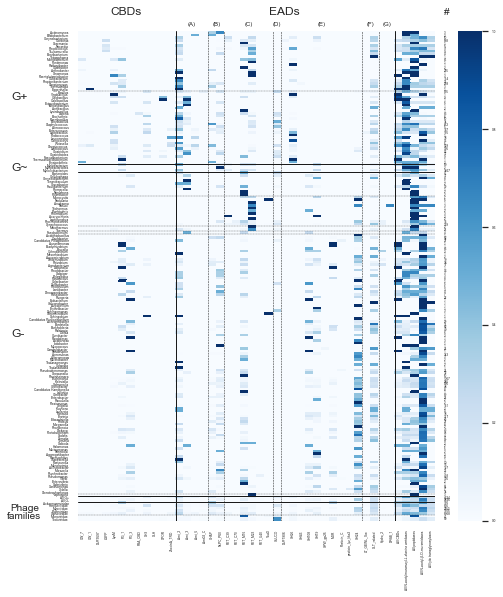

In [24]:
### Create heatmap
plt.figure(figsize=(8, 9))
sb.set(font_scale = 0.3)
plt.tight_layout()
sb.heatmap(pd.DataFrame(domain_genus_quant_wo, index=heatmap_rows, columns=heatmap_cols_wo), cmap='Blues',
                xticklabels=True, yticklabels=True)
plt.axhline(len(gpos), xmin = -0.1, ls='-', lw=1, c='k') #G+ vs G~
plt.text(-8.2, len(gpos)/2 + 1, "G+", fontsize=12)
plt.axhline(len(gpos)+len(gamb), ls='-', lw=1, c='k') #G~ vs G-
plt.text(-8.2, len(gpos)+(len(gamb)/2) + 1.3, "G~", fontsize=12)
plt.text(-8.2, len(gpos)+len(gamb)+(len(gneg)/2) + 1, "G-", fontsize=12)
plt.axhline(len(gpos)+len(gamb)+len(gneg), ls='-', lw=1, c='k') #G- vs summary
plt.axhline(len(gpos)+len(gamb)+len(gneg)+2, ls='-', lw=1, c='k') #summary vs phage fams
plt.text(-8.4, len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2) + 2, "Phage", fontsize=10)
plt.text(-8.75, len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2) + 5, "families", fontsize=10)

plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Firmicutes'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Cyanobacteria'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Deinococcus-Thermus'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Fusobacteria'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Proteobacteria'), ls='--', lw=0.3, c='k')
plt.axhline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Spirochaetes'), ls='--', lw=0.3, c='k')
plt.axhline(heatmap_rows.index('Microviridae'), ls='--', lw=0.3, c='k')

plt.text((len(cbds)/2)-2, -6, "CBDs", fontsize=12)
plt.axvline(len(cbds), ls='-', lw=1, c='k') #CBDs vs EADs
plt.text(len(cbds) + (len(eads)/2)-2, -6, "EADs", fontsize=12)
plt.axvline(len(cbds)+len(eads), ls='-', lw=1, c='k') #EADs vs summary

plt.text(len(cbds)+(len(pgas)/2)-0.5, -2, "(A)", fontsize=6)
plt.axvline(len(cbds)+len(pgas), ls='--', lw=0.5, c='k') #PGAs vs PGAPs
plt.text(len(cbds)+len(pgas)+(len(pgaps)/2)-0.5, -2, "(B)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps), ls='--', lw=0.5, c='k') #PGAPs vs PGPs
plt.text(len(cbds)+len(pgas)+len(pgaps)+(len(pgps)/2)-0.5, -2, "(C)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps), ls='--', lw=0.5, c='k') #PGPs vs PGGs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+(len(pggs)/2)-0.5, -2, "(D)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs), ls='--', lw=0.5, c='k') #PGGs vs PGMs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+(len(pgms)/2)-0.5, -2, "(E)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+(len(pgmts)/2)-0.5, -2, "(F)", fontsize=6)
plt.axvline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts)+(len(pglts)/2)-0.5, -2, "(G)", fontsize=6)

### add genus_counts
plt.text(len(heatmap_cols_wo)+1, -6, "#", fontsize=10)
for idx, i in enumerate(genus_specific_entries):
    plt.text(len(heatmap_cols_wo)+1, idx+0.9, i, fontsize=3)

plt.savefig('figure_6.png', format='png', dpi=600, tight_layout=True)
plt.show()

## Host - Domain quantification

### With various

In [34]:
### Set properties
heatmap_cols = sorted_genera + ['ALL G+', 'ALL G-'] + sorted_phage_fams
heatmap_rows = sorted_doms + ['All CBDs', 'All N-acetylmuramoyl-L-alanine amidases', 'All peptidases', 'All N-acetyl-β-D-muramidases', 'All lytic transglycosylases']

In [35]:
### calculate fraction of accessions for a certain domain that has a specific host
domain_specific_entries = []
genus_domain_quant = np.zeros((len(heatmap_rows), len(heatmap_cols)))
for idx, i in enumerate(heatmap_rows):
    if i == 'All CBDs': #entries that have this host & a binding domain
        entries_dom = [l for l in domains_per_entry if set(cbds).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All N-acetylmuramoyl-L-alanine amidases': #entries that have this host & an amidase
        entries_dom = [l for l in domains_per_entry if set(amidases).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All peptidases': #entries that have this host & a peptidase
        entries_dom = [l for l in domains_per_entry if set(peptidases).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All N-acetyl-β-D-muramidases': #entries that have this host & a muramidase/lysozyme
        entries_dom = [l for l in domains_per_entry if set(muramidases).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All lytic transglycosylases': #entries that have this host & a lytic transglycosylase
        entries_dom = [l for l in domains_per_entry if set(lts).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    else:
        entries_dom = [l for l in domains_per_entry if i in domains_per_entry[l]]
        domain_specific_entries.append(len(entries_dom))
    for jdx, j in enumerate(heatmap_cols):
        entries_dom_known_host = list(set(entries_dom).intersection(set(host_per_entry.keys())))
        if j == 'ALL G+':
            G_pos = set(gpos.Genus)
            entries_dom_host = [k for k in entries_dom_known_host if G_pos.intersection(set(host_per_entry[k]))]
        elif j == 'ALL G-':
            G_neg = set(gneg.Genus)
            entries_dom_host = [k for k in entries_dom_known_host if G_neg.intersection(set(host_per_entry[k]))]
        elif j in sorted_phage_fams:
            entries_dom_host = set([k for k in phage_per_entry if phage_per_entry[k] == j]).intersection(set(entries_dom))
        else:
            entries_dom_host = [k for k in entries_dom_known_host if j in host_per_entry[k]]
        genus_domain_quant[idx, jdx] = len(entries_dom_host)/len(entries_dom) #calculate fraction

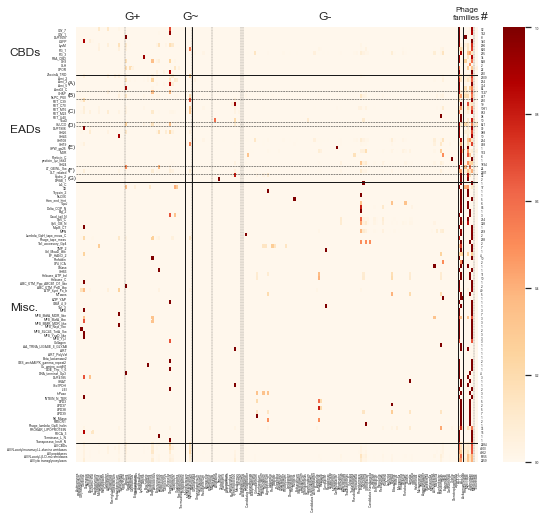

In [36]:
### create heatmap
plt.figure(figsize=(9, 8))
sb.set(font_scale = 0.3)
plt.tight_layout()
sb.heatmap(pd.DataFrame(genus_domain_quant, index=heatmap_rows, columns=heatmap_cols), cmap='OrRd',
                xticklabels=True, yticklabels=True)
plt.axvline(len(gpos), ls='-', lw=1, c='k') #G+ vs G~
plt.text(len(gpos)/2-3, -2, "G+", fontsize=12)
plt.axvline(len(gpos)+len(gamb), ls='-', lw=1, c='k') #G~ vs G-
plt.text(len(gpos)+(len(gamb)/2)-3, -2, "G~", fontsize=12)
plt.text(len(gpos)+len(gamb)+(len(gneg)/2)-3, -2, "G-", fontsize=12)
plt.axvline(len(gpos)+len(gamb)+len(gneg), ls='-', lw=1, c='k') #G- vs summary
plt.axvline(len(gpos)+len(gamb)+len(gneg)+2, ls='-', lw=1, c='k') #summary vs phage fams
plt.text(len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2)-5, -4, "Phage", fontsize=8)
plt.text(len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2)-6, -2, "families", fontsize=8)

plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Firmicutes'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Cyanobacteria'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Bacteroidetes'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Fusobacteria'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Proteobacteria'), ls='--', lw=0.3, c='k')
plt.axvline(heatmap_cols.index('Microviridae'), ls='--', lw=0.3, c='k')

plt.text(-30, (len(cbds)/2)+1, "CBDs", fontsize=12)
plt.axhline(len(cbds), ls='-', lw=1, c='k') #CBDs vs EADs
plt.text(-30, len(cbds) + (len(eads)/2)+1, "EADs", fontsize=12)
plt.axhline(len(cbds)+len(eads), ls='-', lw=1, c='k') #EADs vs misc
plt.text(-30, len(cbds)+len(eads) + (len(misc)/2)-0.5, "Misc.", fontsize=12)
plt.axhline(len(cbds)+len(eads)+len(misc), ls='-', lw=1, c='k') #EADs vs misc

plt.text(-4, len(cbds)+(len(pgas)/2)+0.5, "(A)", fontsize=6)
plt.axhline(len(cbds)+len(pgas), ls='--', lw=0.5, c='k') #PGAs vs PGAPs
plt.text(-4, len(cbds)+len(pgas)+(len(pgaps)/2)+0.5, "(B)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps), ls='--', lw=0.5, c='k') #PGAPs vs PGPs
plt.text(-4, len(cbds)+len(pgas)+len(pgaps)+(len(pgps)/2)+0.5, "(C)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps), ls='--', lw=0.5, c='k') #PGPs vs PGGs
plt.text(-4, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+(len(pggs)/2)+0.5, "(D)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs), ls='--', lw=0.5, c='k') #PGGs vs PGMs
plt.text(-4, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+(len(pgms)/2)+0.5, "(E)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(-4, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+(len(pgmts)/2)+0.5, "(F)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(-4, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts)+(len(pglts)/2)+0.5, "(G)", fontsize=6)

### add domain_counts
plt.text(len(heatmap_cols)+1, -2, "#", fontsize=12)
for idx, i in enumerate(domain_specific_entries):
    plt.text(len(heatmap_cols)+1, idx+0.8, i, fontsize=3)

plt.savefig('S4 Fig.png', format='png', dpi=600)
plt.show()

### Without various

In [37]:
### Set properties
heatmap_cols = sorted_genera + ['ALL G+', 'ALL G-'] + sorted_phage_fams
heatmap_rows_wo = sorted_doms_wo + ['All CBDs', 'All N-acetylmuramoyl-L-alanine amidases', 'All peptidases', 'All N-acetyl-β-D-muramidases', 'All lytic transglycosylases']

In [38]:
### calculate fraction of accessions for a certain domain that has a specific host
domain_specific_entries = []
genus_domain_quant_wo = np.zeros((len(heatmap_rows_wo), len(heatmap_cols)))
for idx, i in enumerate(heatmap_rows_wo):
    if i == 'All CBDs': #entries that have this host & a binding domain
        entries_dom = [l for l in domains_per_entry if set(cbds).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All N-acetylmuramoyl-L-alanine amidases': #entries that have this host & an amidase
        entries_dom = [l for l in domains_per_entry if set(amidases).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All peptidases': #entries that have this host & a peptidase
        entries_dom = [l for l in domains_per_entry if set(peptidases).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All N-acetyl-β-D-muramidases': #entries that have this host & a muramidase/lysozyme
        entries_dom = [l for l in domains_per_entry if set(muramidases).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    elif i == 'All lytic transglycosylases': #entries that have this host & a lytic transglycosylase
        entries_dom = [l for l in domains_per_entry if set(lts).intersection(set(domains_per_entry[l]))]
        domain_specific_entries.append(len(entries_dom))
    else:
        entries_dom = [l for l in domains_per_entry if i in domains_per_entry[l]]
        domain_specific_entries.append(len(entries_dom))
    for jdx, j in enumerate(heatmap_cols):
        entries_dom_known_host = list(set(entries_dom).intersection(set(host_per_entry.keys())))
        if j == 'ALL G+':
            G_pos = set(gpos.Genus)
            entries_dom_host = [k for k in entries_dom_known_host if G_pos.intersection(set(host_per_entry[k]))]
        elif j == 'ALL G-':
            G_neg = set(gneg.Genus)
            entries_dom_host = [k for k in entries_dom_known_host if G_neg.intersection(set(host_per_entry[k]))]
        elif j in sorted_phage_fams:
            entries_dom_host = set([k for k in phage_per_entry if phage_per_entry[k] == j]).intersection(set(entries_dom))
        else:
            entries_dom_host = [k for k in entries_dom_known_host if j in host_per_entry[k]]
        genus_domain_quant_wo[idx, jdx] = len(entries_dom_host)/len(entries_dom) #calculate fraction

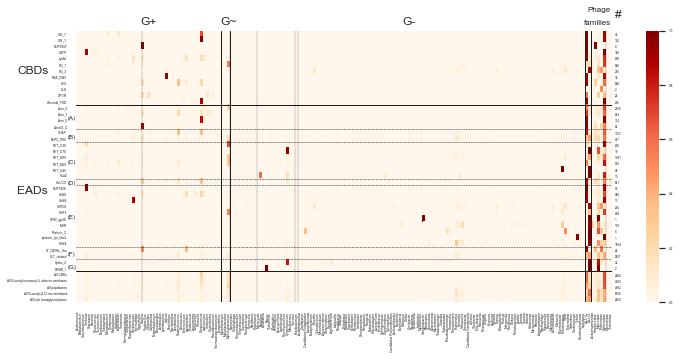

In [39]:
### create heatmap
plt.figure(figsize=(12, 5))
sb.set(font_scale = 0.3)
plt.tight_layout()
sb.heatmap(pd.DataFrame(genus_domain_quant_wo, index=heatmap_rows_wo, columns=heatmap_cols), cmap='OrRd',
                xticklabels=True, yticklabels=True)
plt.axvline(len(gpos), ls='-', lw=1, c='k') #G+ vs G~
plt.text(len(gpos)/2-3, -1, "G+", fontsize=12)
plt.axvline(len(gpos)+len(gamb), ls='-', lw=1, c='k') #G~ vs G-
plt.text(len(gpos)+(len(gamb)/2)-2, -1, "G~", fontsize=12)
plt.text(len(gpos)+len(gamb)+(len(gneg)/2)-2, -1, "G-", fontsize=12)
plt.axvline(len(gpos)+len(gamb)+len(gneg), ls='-', lw=1, c='k') #G- vs summary
plt.axvline(len(gpos)+len(gamb)+len(gneg)+2, ls='-', lw=1, c='k') #summary vs phage fams
plt.text(len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2)-3, -3, "Phage", fontsize=8)
plt.text(len(gpos)+len(gamb)+len(gneg) + (len(sorted_phage_fams)/2)-4, -1, "families", fontsize=8)

plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Firmicutes'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Cyanobacteria'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Bacteroidetes'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Fusobacteria'), ls='--', lw=0.3, c='k')
plt.axvline(list(pd.concat([gpos, gamb, gneg]).Phylum).index('Proteobacteria'), ls='--', lw=0.3, c='k')
plt.axvline(heatmap_cols.index('Microviridae'), ls='--', lw=0.3, c='k')

plt.text(-20, (len(cbds)/2)+1, "CBDs", fontsize=12)
plt.axhline(len(cbds), ls='-', lw=1, c='k') #CBDs vs EADs
plt.text(-20, len(cbds) + (len(eads)/2)+1, "EADs", fontsize=12)
plt.axhline(len(cbds)+len(eads), ls='-', lw=1, c='k') #EADs vs summary

plt.text(-3, len(cbds)+(len(pgas)/2)+0.5, "(A)", fontsize=6)
plt.axhline(len(cbds)+len(pgas), ls='--', lw=0.5, c='k') #PGAs vs PGAPs
plt.text(-3, len(cbds)+len(pgas)+(len(pgaps)/2)+0.5, "(B)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps), ls='--', lw=0.5, c='k') #PGAPs vs PGPs
plt.text(-3, len(cbds)+len(pgas)+len(pgaps)+(len(pgps)/2)+0.5, "(C)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps), ls='--', lw=0.5, c='k') #PGPs vs PGGs
plt.text(-3, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+(len(pggs)/2)+0.5, "(D)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs), ls='--', lw=0.5, c='k') #PGGs vs PGMs
plt.text(-3, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+(len(pgms)/2)+0.5, "(E)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(-3, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+(len(pgmts)/2)+0.5, "(F)", fontsize=6)
plt.axhline(len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts), ls='--', lw=0.5, c='k') #PGMs vs PGMTs
plt.text(-3, len(cbds)+len(pgas)+len(pgaps)+len(pgps)+len(pggs)+len(pgms)+len(pgmts)+(len(pglts)/2)+0.5, "(G)", fontsize=6)

### add domain_counts
plt.text(len(heatmap_cols)+1, -2, "#", fontsize=12)
for idx, i in enumerate(domain_specific_entries):
    plt.text(len(heatmap_cols)+1, idx+0.8, i, fontsize=3)

plt.savefig('S2 Fig.png', format='png', dpi=600)
plt.show()